In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import time
import zipfile
import os
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import r2_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor


In [2]:
zip_file_path = '../Data/clean_df.zip'
csv_file_name = 'clean_df.csv'

# Open the zip file and extract the CSV file to a temporary directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(csv_file_name, 'tmp')

# Read the CSV file into a pandas DataFrame
clean_df = pd.read_csv(f'tmp/{csv_file_name}')

# Clean up the temporary directory by deleting the extracted CSV file
os.remove(f'tmp/{csv_file_name}')

# removing an unnecessary column
clean_df = clean_df.drop(columns='Unnamed: 0')
clean_df.head()

,id_tracks,name_tracks,popularity_tracks,explicit,danceability,energy,key,loudness,mode,speechiness,...,followers,genres,name_artists,popularity_artists,duration_ms_log,year,month,day,dayofweek,weekofyear
0,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,0,0.434,0.1770,1,-21.180,1,0.0512,...,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,12.109782,1922,3,21,1,12
1,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,0,0.321,0.0946,7,-27.961,1,0.0504,...,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,12.083379,1922,3,21,1,12
2,0JV4iqw2lSKJaHBQZ0e5zK,Martín Fierro - Remasterizado,0,0,0.548,0.0391,6,-23.228,1,0.1530,...,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,12.107208,1922,3,29,2,13
3,0l3BQsVJ7F76wlN5QhJzaP,El Vendaval - Remasterizado,0,0,0.370,0.3720,2,-17.138,1,0.0865,...,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,11.941671,1922,3,21,1,12
4,0xJCJ9XSNcdTIz0QKmhtEn,La Maleva - Remasterizado,0,0,0.339,0.0958,8,-26.944,1,0.0530,...,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,12.108680,1922,3,29,2,13


In [3]:
num_features = ['explicit', 'danceability', 'energy', 'key',
                'loudness', 'mode', 'speechiness', 'acousticness',
                'instrumentalness', 'liveness', 'valence', 'tempo',
                'time_signature', 'followers', 'popularity_artists', 'duration_ms_log']
cat_features = ['id_tracks', 'name_tracks', 'id_artists', 'name_artists']
date_feature = ['year', 'month', 'day', 'dayofweek', 'weekofyear']
other_feature = ['genres']
target = ['popularity_tracks']

Since we only have 4 categorical features that are just identifiers of the tracks, I chose to ignore them for my training techniques and just focus on the numerical features that represent the actual audio features of a track

In [4]:
# split data into features and target
clean_df_X = clean_df[num_features]
clean_df_y = clean_df[target]

# Split the dataset into development (80%) and test (20%) sets.
clean_df_X_dev, clean_df_X_test, clean_df_y_dev, clean_df_y_test = train_test_split(clean_df_X, clean_df_y, test_size=0.2, random_state=42)
print(clean_df_X_dev.shape)
print(clean_df_X_test.shape)

(345782, 16)
(86446, 16)


# Classification

## Gradient Boosting
<img src="./gradient_screenshots/xgb_classifier.png">

# Regression

## Gradient Boosting
<img src="./gradient_screenshots/baseline_gradient.png">

### Baseline

### Tuned Gradient Boosting Regressor
<img src="./gradient_screenshots/tuned_gradient.png">

## XGBoosting

### Baseline

In [7]:
XGBoost = XGBRegressor(random_state=42)
XGBoost.fit(clean_df_X_dev, clean_df_y_dev)

clean_df_y_dev_pred = XGBoost.predict(clean_df_X_dev)
clean_df_y_test_pred = XGBoost.predict(clean_df_X_test)
dev_accuracy = r2_score(clean_df_y_dev, clean_df_y_dev_pred)
test_accuracy = r2_score(clean_df_y_test, clean_df_y_test_pred)
print("======Baseline XGBoost Regressor======")
print("R2 score on dev data: ", dev_accuracy)
print("R2 score on test data: ", test_accuracy)

======Baseline XGBoost Regressor======
R2 score on dev data:  0.543513183503445
R2 score on test data:  0.5108046701830479


### Hyperparameter Tuning

I chose to tune for the following hyperparameters: n_estimators, learning_rate, and max_depth.

Since this process run for a long time (more than 3 hours) and did not finish, I am going to include the code a screenshot of the code I used as well as the partial results that I got.

<img src="./gradient_screenshots/grid_search.png">

From the hyperparameter tuning, we can see that the most optimal results are given by:
- n_estimators = 250
- learning_rate = 0.1
- max_depth = 10

Given the fact that results improved when we increased n_estimators from 100 to 250, given a learning rate of 0.1 and a max-depth of 10, I hypothesized that a higher number of trees (or n_estimators) leads to an improvement in scores.

Therefore, I chose to retrain the model with:
- n_estimators = 500
- learning_rate = 0.1
- max_depth = 10

### Optimal XGBoosting

In [11]:
XGBoost = XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.1, max_depth=10)
XGBoost.fit(clean_df_X_dev, clean_df_y_dev)

clean_df_y_dev_pred = XGBoost.predict(clean_df_X_dev)
clean_df_y_test_pred = XGBoost.predict(clean_df_X_test)

dev_accuracy = r2_score(clean_df_y_dev, clean_df_y_dev_pred)
test_accuracy = r2_score(clean_df_y_test, clean_df_y_test_pred)
print("XGBoost after hyperparameter tuning")
print("R2 score on dev data: ", dev_accuracy)
print("R2 score on test data: ", test_accuracy)

XGBoost after hyperparameter tuning
R2 score on dev data:  0.7523710622602877
R2 score on test data:  0.5591151724501486


#### Feature Importance  

The top 8 most important features for this trained tree are:  ['popularity_artists', 'explicit', 'loudness', 'acousticness', 'followers', 'duration_ms_log', 'instrumentalness', 'valence']


Text(0.5, 1.0, 'Feature Importances from XGBoost Model')

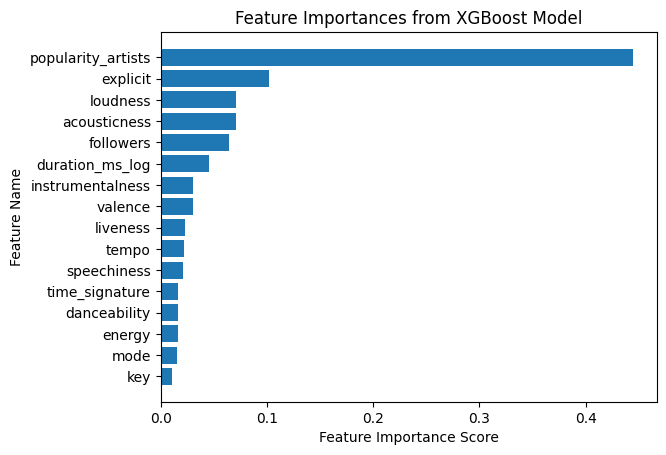

In [19]:
feature_importances = XGBoost.feature_importances_
feature_names = XGBoost.feature_names_in_
feature_importance_df = pd.DataFrame(
    {'feature_names':feature_names,
     'feature_importances':feature_importances
    })
feature_importance_df = feature_importance_df.sort_values(by='feature_importances', ascending=False)
important_features = list(feature_importance_df['feature_names'])
print("The top 8 most important features for this trained tree are: ", important_features[:8])

fig, ax = plt.subplots()
ax.barh(feature_importance_df['feature_names'], feature_importance_df['feature_importances'])
ax.invert_yaxis()
ax.set_xlabel('Feature Importance Score')
ax.set_ylabel('Feature Name')
ax.set_title('Feature Importances from XGBoost Model')

#### Optimal XGBoost after Feature Importance

##### Top 8 Features

In [20]:
feat_X_dev = clean_df_X_dev[['popularity_artists', 'explicit', 'loudness', 'acousticness', 'followers', 'duration_ms_log', 'instrumentalness', 'valence']]
feat_X_test = clean_df_X_test[['popularity_artists', 'explicit', 'loudness', 'acousticness', 'followers', 'duration_ms_log', 'instrumentalness', 'valence']]

XGBoost = XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.1, max_depth=10)
XGBoost.fit(feat_X_dev, clean_df_y_dev)

y_dev_pred = XGBoost.predict(feat_X_dev)
y_test_pred = XGBoost.predict(feat_X_test)

dev_accuracy = r2_score(clean_df_y_dev, y_dev_pred)
test_accuracy = r2_score(clean_df_y_test, y_test_pred)

print("XGBoost with top 8 features")
print("R2 score on dev data: ", dev_accuracy)
print("R2 score on test data: ", test_accuracy)

XGBoost with top 8 features
R2 score on dev data:  0.7124530049458058
R2 score on test data:  0.5592703357808885


##### Top 6 Features

In [21]:
feat_X_dev = clean_df_X_dev[['popularity_artists', 'explicit', 'loudness', 'acousticness', 'followers', 'duration_ms_log']]
feat_X_test = clean_df_X_test[['popularity_artists', 'explicit', 'loudness', 'acousticness', 'followers', 'duration_ms_log']]

XGBoost = XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.1, max_depth=10)
XGBoost.fit(feat_X_dev, clean_df_y_dev)

y_dev_pred = XGBoost.predict(feat_X_dev)
y_test_pred = XGBoost.predict(feat_X_test)

dev_accuracy = r2_score(clean_df_y_dev, y_dev_pred)
test_accuracy = r2_score(clean_df_y_test, y_test_pred)

print("XGBoost with top 6 features")
print("R2 score on dev data: ", dev_accuracy)
print("R2 score on test data: ", test_accuracy)

XGBoost with top 6 features
R2 score on dev data:  0.6900363824987681
R2 score on test data:  0.5610343373519205


##### Top 4 Features

In [22]:
feat_X_dev = clean_df_X_dev[['popularity_artists', 'explicit', 'loudness', 'acousticness']]
feat_X_test = clean_df_X_test[['popularity_artists', 'explicit', 'loudness', 'acousticness']]

XGBoost = XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.1, max_depth=10)
XGBoost.fit(feat_X_dev, clean_df_y_dev)

y_dev_pred = XGBoost.predict(feat_X_dev)
y_test_pred = XGBoost.predict(feat_X_test)

dev_accuracy = r2_score(clean_df_y_dev, y_dev_pred)
test_accuracy = r2_score(clean_df_y_test, y_test_pred)

print("XGBoost with top 4 features")
print("R2 score on dev data: ", dev_accuracy)
print("R2 score on test data: ", test_accuracy)

XGBoost with top 4 features
R2 score on dev data:  0.54205742047492
R2 score on test data:  0.41070809514679985
